# Advanced Gaussian sources

Tidy3D natively offers sources like ModeSource, PlaneWave, GaussianBeam, etc. However, due to the python and open-source nature of Tidy3D, we can easily define arbitrary sources such as vortex beams. In this notebook, we demonstrate how to create these advanced sources in a way that is easily usable in multiple scenarios.
<br><br>
It can often be tedious to create easily usable customized simulation objects from scratch, as there are various details to consider. For instance, if one wants to create an easily-usable beam source from scratch, one must create functionality to automatically interpret the source plane into field coordinates, handle conversion for polar and azimuthal angles, handle different direction specifications, etc. This all becomes very complicated to build, so there is often a tradeoff between ease of construction and ease of use.
<br><br>
Fortunately, we can take advantage of the fact that Tidy3D's [Python frontend](https://github.com/flexcompute/tidy3d/tree/981c0ebb22ba4dd317818ebc3729edb1e0005f2f) is open source is open source to create complex Gaussian sources without needing to consider any of these extraneous functionalities. Namely, we use the Tidy3D [BeamProfile](https://github.com/flexcompute/tidy3d/blob/develop/tidy3d/components/beam.py) class to handle all extra usability considerations, so we only need to define the scalar field profile for the propagation direction. The BeamProfile object will then automatically create, interpolate, and rotate the field amplitudes according to the geometry of the source plane and specified angles.
<br><br>
This is just one way in which we can take advantage of the open source nature of Tidy3D, and these principles can be applied to any base object class that Tidy3D provides.

In [1]:
# Standard python imports
import matplotlib.pyplot as plt
import numpy as np

# Tidy3D import
import tidy3d as td
from tidy3d import web

If we look at how Tidy3D's GaussianBeam uses the abstract BeamProfile class, we see that the BeamProfile class already handles polarization angles, propagation angles, sourcetimes, direction, and can interpret user-defined source plane geometry. Thus we need only define the extra parameters our advanced Gaussian sources need on top of these. With each source, we will demonstrate its use after defining it as an object.

## Hermite-Gaussian source

Here we show how to create a Hermite-Gaussian mode in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the field profile change along the propagation direction.<br><br>
In cartesian coordinates, where $x$ is the propagation direction, the mode has field profile

<center>$E_{l,m}(x,y,z)=E_0\frac{\omega_0}{\omega(z)}H_l(\frac{\sqrt{2}x}{\omega(z)}) H_m(\frac{\sqrt{2}y}{\omega(z)})\exp(-\frac{x^2+y^2}{\omega^2(z)})\exp(-i\frac{k(x^2+y^2)}{2R(z)})\exp( i\psi(x))\exp( -ikz)$</center>

where:
<li>$\omega_0$ is the beam waist</li>
<li>$z_R=\frac{\pi n_\epsilon\omega_0^2}{\lambda}$ is the Rayleigh length</li>
<li>$\omega(z)=\omega_0\sqrt{1+\frac{z^2}{z_R^2}}$ is the beam radius</li>
<li>$k=\frac{2\pi n}{\lambda}$ is the wavenumber</li>
<li>$R(z)=z(1+\frac{z_R^2}{z^2})$ is the wavefront curvature</li>
<li>$H_l,H_m$ are Hermite polynomials of orders $l$ and $m$</li>
<li>$\psi(z)=(l+m+1)\arctan(\frac{z}{z_R})$ is the phase function</li>

In [2]:
from scipy.special import hermite
from tidy3d.components.beam import BeamProfile


def HGM(
    size,
    m,
    l,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    freqs = [source_time.freq0]

    class HGM_obj(BeamProfile):
        """Component for constructing HGM beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for HGM beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance

            zR = np.pi * background_n * w0**2 / (td.C_0 / np.array(self.freqs))
            wz = w0 * np.sqrt(1 + z**2 / zR**2)
            Rz = td.inf if np.any(z == 0) else z * (1 + zR**2 / z**2)
            k = 2 * np.pi * np.array(self.freqs) / td.C_0 * background_n
            psi_z = (l + m + 1) * np.arctan(z / zR)

            E = source_time.amplitude * w0 / wz
            E *= hermite(l)(np.real(np.sqrt(2) * x / wz)) * hermite(m)(np.real(np.sqrt(2) * y / wz))
            E *= np.exp(-(x**2 + y**2) / wz**2) * np.exp(-1j * k * (x**2 + y**2) / (2 * Rz))
            E *= np.exp(1j * psi_z) * np.exp(-1j * k * z)

            return E

    HGM_obj = HGM_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = HGM_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    HGM_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return HGM_source

Create and run an example $m=2,l=1$ Hermite-Gaussian beam. To ensure that the BeamProfile object is working correctly, we specify extra angles and a non-unity beam waist:

In [3]:
freq0 = td.C_0 / 1.55
hgm = HGM(
    size=(0, 4, 4),
    m=2,
    l=1,
    w0=1.2,
    pol_angle=np.pi / 24,
    angle_phi=np.pi / 36,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
)

In [4]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

HGM_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[hgm],
    monitors=field_monitors,
    run_time=1e-13,
)

In [5]:
hgm_sim_data = web.run(simulation=HGM_test_sim, task_name="HGM test")

18:52:16 CEST Created task 'HGM test' with task_id                              
              'fdve-172b0513-74a4-4790-a054-2b20f4f557c6' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=563480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=467013;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\taskId]8;;\]8;id=563480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\=]8;;\]8;id=760617;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\fdve]8;;\]8;id=563480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\-172b0513-74]8;;\
              ]8;id=563480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\a4-4790-a054-2b20f4f557c6']8;;\.

              Task folder: ]8;id=17807;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

18:52:19 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:52:20 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:52:52 CEST status = preprocess

18:52:56 CEST starting up solver

              running solver

Output()

18:52:57 CEST early shutoff detected at 92%, exiting.

              status = postprocess

Output()

18:53:08 CEST status = success

18:53:10 CEST View simulation result at                                         
              ]8;id=473550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=103651;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\taskId]8;;\]8;id=473550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\=]8;;\]8;id=184122;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\fdve]8;;\]8;id=473550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\-172b0513-74]8;;\
              ]8;id=473550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-172b0513-74a4-4790-a054-2b20f4f557c6\a4-4790-a054-2b20f4f557c6']8;;\.

Output()

18:53:13 CEST loading simulation from simulation_data.hdf5

Display field in propagation direction:

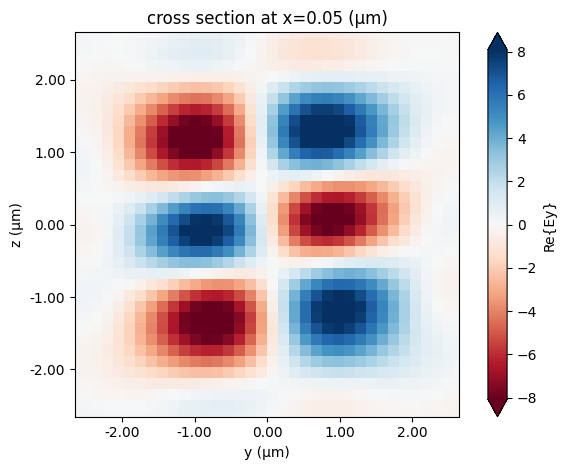

In [6]:
hgm_sim_data.plot_field(str(field_monitor_xs[0]), "Ey", f=freq0)
plt.show()

To see how the field evolves, run the following code to visualize along the propagation direction.

In [7]:
import ipywidgets as widgets

component = "Ey"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    hgm_sim_data.plot_field(str(x), component, f=freq0)
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='Ey', max=5.0, min=0.0500000000000001…

## Laguerre-Gaussian source

Here we show how to create an Orbital Angular Momentum (OAM) beam in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the field profile change along the propagation direction.<br><br>
In cylindrical coordinates, where $z$ is the propagation direction, the OAM has field profile

<center>$E_{l,p}(r,\phi,z)=E_0\sqrt{\frac{2p!}{\pi(p+|l|)!}} \frac{1}{\omega(z)} (\frac{r\sqrt{2}}{\omega(z)})^{|l|} \exp(-\frac{r^2}{\omega^2(z)}) L_p^{|l|}(\frac{2r^2}{\omega^2(z)}) \exp(-ik\frac{r^2}{2R(z)}) \exp(-il\phi) \exp( i\psi(z))$</center>

where:
<li>$\omega_0$ is the beam waist</li>
<li>$z_R=\frac{\pi n_\epsilon\omega_0^2}{\lambda}$ is the Rayleigh length</li>
<li>$\omega(z)=\omega_0\sqrt{1+\frac{z^2}{z_R^2}}$ is the beam radius</li>
<li>$R(z)=z(1+\frac{z_R^2}{z^2})$ is the wavefront curvature</li>
<li>$k=\frac{2\pi n}{\lambda}$ is the wavenumber</li>
<li>$L_p^{|l|}$ is the generalized Laguerre polynomial</li>
<li>$\psi(z)=(|l| + 2p + 1)\arctan(\frac{z}{z_R})$ is the phase function</li>

In [8]:
from scipy.special import factorial, genlaguerre


def OAM(
    size,
    p,
    l,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    freqs = [source_time.freq0]

    class OAM_obj(BeamProfile):
        """Component for constructing OAM beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for OAM beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y, x)
            absl = np.abs(l)

            zR = np.pi * background_n * w0**2 / (td.C_0 / np.array(self.freqs))
            wz = w0 * np.sqrt(1 + z**2 / zR**2)
            Rz = td.inf if np.any(z == 0) else z * (1 + zR**2 / z**2)
            k = 2 * np.pi * np.array(self.freqs) / td.C_0 * background_n
            psi_z = (np.abs(l) + 2 * p + 1) * np.arctan(z / zR)

            E = genlaguerre(p, absl)(2 * r**2 / wz**2) if p != 0 else 1
            E *= (
                source_time.amplitude
                * np.sqrt(2 * factorial(p) / (np.pi * factorial(p + absl)))
                / wz
            )
            E *= (r * np.sqrt(2) / wz) ** absl * np.exp(-(r**2) / wz**2)
            E *= np.exp(-1j * k * r**2 / (2 * Rz)) * np.exp(-1j * l * phi) * np.exp(1j * psi_z)

            return E

    OAM_obj = OAM_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = OAM_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    OAM_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return OAM_source

We will demonstrate this functionality by defining a $p=0,l=1$ OAM source that propagates in the $x$ direction:

In [9]:
freq0 = td.C_0 / 1.55
oam = OAM(
    size=(0, 4, 4),
    p=0,
    l=1,
    # pol_angle=-np.pi/24,
    # angle_theta=-np.pi/6,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
)

Create and run an example Laguerre-Gaussian (OAM) beam:

In [10]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

OAM_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[oam],
    monitors=field_monitors,
    run_time=1e-13,
)

In [11]:
oam_sim_data = web.run(simulation=OAM_test_sim, task_name="OAM test")

18:53:14 CEST Created task 'OAM test' with task_id                              
              'fdve-39d8041c-730d-4ba7-98d1-187df97383b0' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=280246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=762912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\taskId]8;;\]8;id=280246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\=]8;;\]8;id=804996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\fdve]8;;\]8;id=280246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\-39d8041c-73]8;;\
              ]8;id=280246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\0d-4ba7-98d1-187df97383b0']8;;\.

              Task folder: ]8;id=459467;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

18:53:17 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:53:18 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:53:38 CEST starting up solver

18:53:39 CEST running solver

Output()

              early shutoff detected at 92%, exiting.

18:53:40 CEST status = postprocess

Output()

18:53:49 CEST status = success

18:53:51 CEST View simulation result at                                         
              ]8;id=725472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=795740;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\taskId]8;;\]8;id=725472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\=]8;;\]8;id=802448;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\fdve]8;;\]8;id=725472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\-39d8041c-73]8;;\
              ]8;id=725472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-39d8041c-730d-4ba7-98d1-187df97383b0\0d-4ba7-98d1-187df97383b0']8;;\.

Output()

18:53:53 CEST loading simulation from simulation_data.hdf5

Display field in propagation direction:

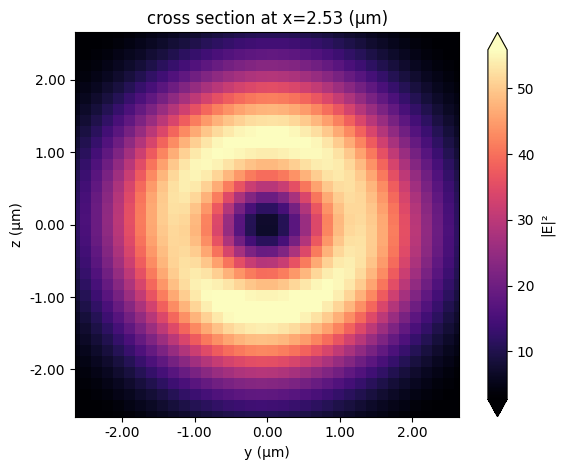

In [12]:
oam_sim_data.plot_field(str(field_monitor_xs[30]), "E", f=freq0, val="abs^2")
plt.show()

To see how the field amplitude evolves, run the following code to visualize along the propagation direction.

In [13]:
import ipywidgets as widgets

component = "E"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    oam_sim_data.plot_field(str(x), component, f=freq0, val="abs^2")
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='E', max=5.0, min=0.05000000000000018…

## Bessel beam source

Here we show how to create an Bessel beam in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the field amplitude change along the propagation direction.<br><br>
In cylindrical coordinates $(\rho, \phi, z)$, where $z$ is the propagation direction, the Bessel beam has field profile

<center>$U_\beta(r)=J_m(k_T\rho)e^{im\phi}e^{-i\beta z}$</center>

where:
<li>$k=\frac{2\pi n}{\lambda}$ is the wavenumber</li>
<li>$J_m$ is the Bessel function of the first kind and $m^{th}$ order</li>
<li>$k_T=\sqrt{k^2-\beta^2}$</li>
<br>
Source: Saleh & Teich, <i>Fundamentals of Photonics</i>

In [14]:
from scipy.special import jv


def Bessel(
    size,
    m,
    beta,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    if not isinstance(m, int):
        raise Exception("Error: m must be an integer")
    freqs = [source_time.freq0]

    class Bessel_obj(BeamProfile):
        """Component for constructing Bessel beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for Bessel beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance
            rho = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y, x)

            k = 2 * np.pi * np.array(self.freqs) / td.C_0 * background_n
            k_T = np.sqrt(k**2 - beta**2)

            E = source_time.amplitude * jv(m, k_T * rho)
            E *= np.exp(1j * m * phi) * np.exp(-1j * beta * z)

            return E

    Bessel_obj = Bessel_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = Bessel_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    Bessel_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return Bessel_source

Create and run example a $m=0,\beta=0$ Bessel beam:

In [15]:
freq0 = td.C_0 / 1.55
bessel = Bessel(
    size=(0, 4, 4), m=0, beta=0, source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10)
)

In [16]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

Bessel_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[bessel],
    monitors=field_monitors,
    run_time=1e-13,
)

In [17]:
bessel_sim_data = web.run(simulation=Bessel_test_sim, task_name="Bessel test")

18:53:56 CEST Created task 'Bessel test' with task_id                           
              'fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=527796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=949308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\taskId]8;;\]8;id=527796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\=]8;;\]8;id=891065;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\fdve]8;;\]8;id=527796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\-0c016bb4-56]8;;\
              ]8;id=527796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\a1-43d3-868f-b596fe51ec60']8;;\.

              Task folder: ]8;id=394077;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

18:53:59 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:54:00 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:54:16 CEST starting up solver

              running solver

Output()

18:54:17 CEST early shutoff detected at 92%, exiting.

              status = postprocess

Output()

18:54:24 CEST status = success

18:54:26 CEST View simulation result at                                         
              ]8;id=788196;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=205844;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\taskId]8;;\]8;id=788196;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\=]8;;\]8;id=129493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\fdve]8;;\]8;id=788196;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\-0c016bb4-56]8;;\
              ]8;id=788196;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c016bb4-56a1-43d3-868f-b596fe51ec60\a1-43d3-868f-b596fe51ec60']8;;\.

Output()

18:54:29 CEST loading simulation from simulation_data.hdf5

Display field amplitude in propagation direction:

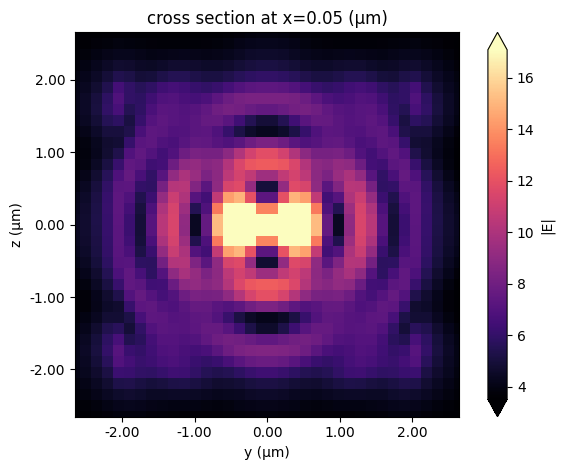

In [18]:
bessel_sim_data.plot_field(str(field_monitor_xs[0]), "E", val="abs", f=freq0)
plt.show()

To see how the field amplitude evolves, run the following code to visualize along the propagation direction.

In [19]:
import ipywidgets as widgets

component = "E"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    bessel_sim_data.plot_field(str(x), component, val="abs", f=freq0)
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='E', max=5.0, min=0.05000000000000018…

## Hyper-geometric Gaussian source

Here we show how to create a Hyper-geometric Gaussian (HGG) beam in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the field profile change along the propagation direction.<br><br>
In cylindrical coordinates, where $\rho=\frac{r}{\omega_0}$ is the normalized radial coordinate and $Z=\frac{z}{z_R}$ is the normalized longitude direction (the direction of propagation), the HGG has field profile

<center>$E_{p,m}(\rho,\phi,Z)=\sqrt{\frac{2^{p+|m|+1}}{\pi\Gamma(p+|m|+1)}}\frac{\Gamma(\frac{p}{2}+|m|+1)}{\Gamma(|m|+1)}i^{|m|+1}Z^{\frac{p}{2}}( Z+i)^{-(\frac{p}{2}+|m|+1)}\rho^{|m|}\exp(-\frac{i\rho^2}{Z+i}) e^{im\phi} {_1}F_1(-\frac{p}{2},|m|+1;\frac{\rho^2}{Z(Z+i)})$</center>

where:
<li>$\omega_0$ is the beam waist</li>
<li>$z_R=\frac{\pi n_\epsilon\omega_0^2}{\lambda}$ is the Rayleigh length</li>
<li>$m$ is the rotational index</li>
<li>$p\geq-|m|$</li>
<li>$\Gamma(x)$ is the gamma function</li>
<li>${_1}F_1(a,b;x)$ is a confluent hypergeometric function</li>

In [20]:
from scipy.special import gamma, hyp1f1


def HGG(
    size,
    p,
    m,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    if p < -np.abs(m):
        raise Exception("Error: p must be greater than or equal to -|m|")
    freqs = [source_time.freq0]

    class HGG_obj(BeamProfile):
        """Component for constructing HGG beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for HGG beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance

            r = np.sqrt(x**2 + y**2) / w0
            phi = np.arctan2(y, x)
            abs_m = np.abs(m)

            E = source_time.amplitude * np.sqrt(
                2 ** (p + abs_m + 1) / (np.pi * gamma(p + abs_m + 1))
            )

            Z = z / (np.pi * background_n * w0**2 / (td.C_0 / np.array(self.freqs)))
            if np.all(Z) == 0:
                return E * r ** (p + abs_m) * np.exp(-(r**2) + 1j * m * phi)

            E *= gamma(p / 2 + abs_m + 1) / gamma(abs_m + 1) * 1j ** (abs_m + 1) * Z ** (p / 2)
            E *= (Z + 1j) ** (-(p / 2 + abs_m + 1)) * r**abs_m * np.exp(-(1j * r**2) / (Z + 1j))
            E *= np.exp(1j * m * phi) * hyp1f1(-p / 2, abs_m + 1, r**2 / (Z * (Z + 1j)))

            return E

    HGG_obj = HGG_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = HGG_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    HGG_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return HGG_source

Create and run an example $p=1,m=2$ HGG beam:

In [21]:
freq0 = td.C_0 / 1.55
hgg = HGG(size=(0, 4, 4), p=1, m=2, source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10))

In [22]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

HGG_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[hgg],
    monitors=field_monitors,
    run_time=1e-13,
)

In [23]:
hgg_sim_data = web.run(simulation=HGG_test_sim, task_name="HGG test")

18:54:30 CEST Created task 'HGG test' with task_id                              
              'fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=726190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=291528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\taskId]8;;\]8;id=726190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\=]8;;\]8;id=170337;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\fdve]8;;\]8;id=726190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\-0cc026a6-2a]8;;\
              ]8;id=726190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\28-4d39-ac24-9606481f5e57']8;;\.

              Task folder: ]8;id=34862;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

18:54:33 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

18:54:34 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

18:55:03 CEST status = preprocess

18:55:07 CEST starting up solver

18:55:08 CEST running solver

Output()

              early shutoff detected at 92%, exiting.

              status = postprocess

Output()

18:55:17 CEST status = success

18:55:19 CEST View simulation result at                                         
              ]8;id=993413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=423033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\taskId]8;;\]8;id=993413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\=]8;;\]8;id=703436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\fdve]8;;\]8;id=993413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\-0cc026a6-2a]8;;\
              ]8;id=993413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0cc026a6-2a28-4d39-ac24-9606481f5e57\28-4d39-ac24-9606481f5e57']8;;\.

Output()

18:55:22 CEST loading simulation from simulation_data.hdf5

Display field in propagation direction:

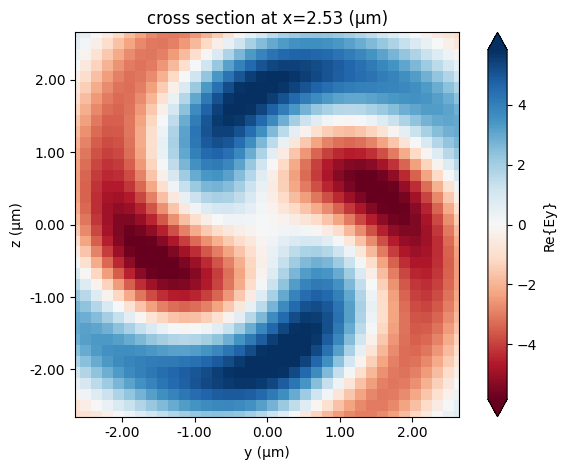

In [24]:
hgg_sim_data.plot_field(str(field_monitor_xs[30]), "Ey", f=freq0)
plt.show()

To see how the field evolves, run the following code to visualize along the propagation direction.

In [25]:
import ipywidgets as widgets

component = "Ey"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    hgg_sim_data.plot_field(str(x), component, f=freq0)
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='Ey', max=5.0, min=0.0500000000000001…